Label encoding: {'cats': [1, 0], 'dogs': [0, 1]}
x_train shape: (2000,)
y_train shape: (2000, 2)
x_test shape: (1000,)
y_test shape: (1000, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2023665..2.2868114].


Computed mu: [[[0.47866336 0.4530665  0.41383895]]]
Computed sigma: [[[0.25900155 0.2521795  0.2563224 ]]]
Debug (c:\Users\uhtin\OneDrive\Desktop\MLPROD\Datasets\cats_and_dogs_filtered\validation\cats\cat.2000.jpg): shape=(224, 224, 3), min=-1.2024, max=2.2868, mean=0.1527, std=0.8714
Debug (c:\Users\uhtin\OneDrive\Desktop\MLPROD\Datasets\cats_and_dogs_filtered\validation\cats\cat.2001.jpg): shape=(224, 224, 3), min=-1.3490, max=2.2868, mean=0.0597, std=1.0249
Debug (c:\Users\uhtin\OneDrive\Desktop\MLPROD\Datasets\cats_and_dogs_filtered\validation\cats\cat.2002.jpg): shape=(224, 224, 3), min=-1.8481, max=2.2868, mean=0.4041, std=1.1838
Overall sample batch stats:
Min: -1.84811
Max: 2.2868114
Mean: 0.061026406
Std: 0.9936983


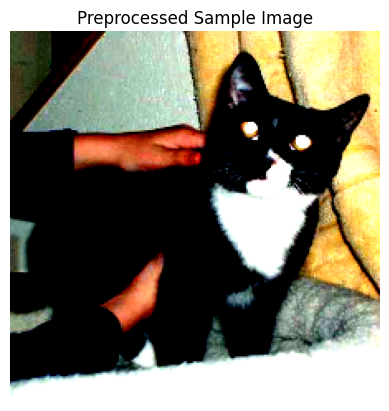

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

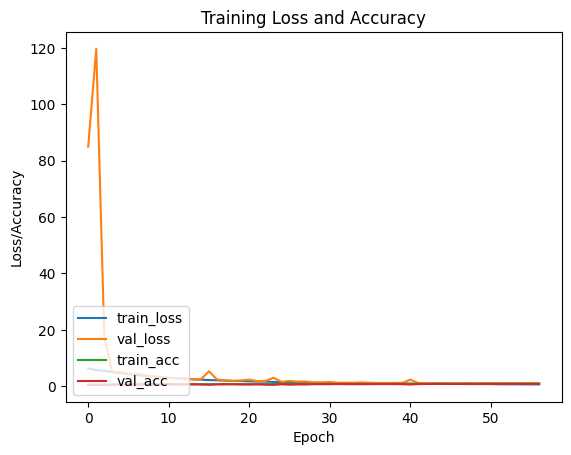

In [4]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Input, Add, GlobalAveragePooling2D, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet50 import preprocess_input

#############################################
# 1. Compute Dataset-Specific μ and σ
#############################################
def compute_dataset_mean_std(image_paths, input_size=224, sample_size=500):
    if sample_size < len(image_paths):
        indices = np.random.choice(len(image_paths), sample_size, replace=False)
        sample_paths = [image_paths[i] for i in indices]
    else:
        sample_paths = image_paths

    imgs = []
    for path in sample_paths:
        try:
            img = tf.io.read_file(path)
            img = tf.image.decode_image(img, channels=3)
            img = tf.image.resize(img, [input_size, input_size])
            img = tf.cast(img, tf.float32) / 255.0  # simple normalization for stats
            imgs.append(img)
        except Exception as e:
            print(f"Error processing {path}: {str(e)}")
    imgs = tf.stack(imgs)
    mu = tf.reduce_mean(imgs, axis=[0, 1, 2]).numpy()
    sigma = tf.math.reduce_std(imgs, axis=[0, 1, 2]).numpy()
    return mu, sigma

#############################################
# 2. Preprocessing Functions
#############################################
def resnet_preprocess(image):
    """Uses Keras ResNet50 preprocessing."""
    return preprocess_input(image)

def simple_normalize(image):
    """Scales image pixels to [0,1]."""
    return image / 255.0

def dataset_standardize(image, mu, sigma):
    """Standardize image using dataset-specific μ and σ."""
    image = image / 255.0
    return (image - mu) / sigma

#############################################
# 3. Custom Data Generator with Debugging
#############################################
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, Y, batch_size=8, input_size=224, shuffle=True,
                 data_aug=True, preprocessing_method='simple', mu=None, sigma=None,
                 debug=False, debug_max=3):
        """
        preprocessing_method: 'simple', 'resnet', or 'dataset'
        If 'dataset' is chosen, mu and sigma must be provided.
        """
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.batch_size = batch_size
        self.IMG_SIZE = input_size
        self.shuffle = shuffle
        self.data_aug = data_aug
        self.preprocessing_method = preprocessing_method.lower()
        self.mu = mu
        self.sigma = sigma
        self.debug = debug
        self.debug_max = debug_max
        self.debug_counter = 0
        
        self.augmentation_pipeline = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ])
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    
    def __img_preprocess(self, image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, [self.IMG_SIZE, self.IMG_SIZE])
        image = tf.cast(image, tf.float32)  # [0,255]
        
        if self.data_aug:
            image = self.augmentation_pipeline(image)
        
        if self.preprocessing_method == 'resnet':
            image = resnet_preprocess(image)
        elif self.preprocessing_method == 'dataset':
            if self.mu is None or self.sigma is None:
                raise ValueError("For 'dataset' preprocessing, mu and sigma must be provided.")
            image = dataset_standardize(image, self.mu, self.sigma)
        else:
            image = simple_normalize(image)
        
        if self.debug and self.debug_counter < self.debug_max:
            img_np = image.numpy()
            print(f"Debug ({image_path}): shape={img_np.shape}, min={img_np.min():.4f}, max={img_np.max():.4f}, mean={img_np.mean():.4f}, std={img_np.std():.4f}")
            self.debug_counter += 1
        return image
    
    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.Y[idx * self.batch_size : (idx + 1) * self.batch_size]
        return self.__get_data(batch_x, batch_y)
    
    def __get_data(self, x_batches, y_batches):
        X_batches = []
        Y_batches = []
        for x, y in zip(x_batches, y_batches):
            try:
                img = self.__img_preprocess(x)
                X_batches.append(img)
                Y_batches.append(y)
            except Exception as e:
                print(f"Error processing {x}: {str(e)}")
                continue
        return tf.stack(X_batches), tf.stack(Y_batches)
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.random.permutation(len(self.X))
            self.X = self.X[indices]
            self.Y = self.Y[indices]
            self.debug_counter = 0

#############################################
# 4. Utility Functions for Dataset Loading
#############################################
def create_label_encoder(dataset_path):
    classes = sorted(os.listdir(dataset_path))
    return {cls: [int(i == idx) for i in range(len(classes))]
            for idx, cls in enumerate(classes)}

def load_dataset(dataset_path: str, label_encode: dict):
    total_files = sum(len(files) for _, _, files in os.walk(dataset_path))
    x_data = np.empty(total_files, dtype=object)
    y_data = np.empty((total_files, len(label_encode)), dtype=int)
    index = 0
    for cur_class in os.listdir(dataset_path):
        temp_path = os.path.join(dataset_path, cur_class)
        for filename in os.listdir(temp_path):
            img_path = os.path.join(temp_path, filename)
            encoded_label = label_encode[cur_class]
            x_data[index] = img_path
            y_data[index] = encoded_label
            index += 1
    return x_data, y_data

#############################################
# 5. Set Paths and Create Generators
#############################################
base_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
train_path = os.path.join(base_path, "Datasets", "cats_and_dogs_filtered", "train")
test_path = os.path.join(base_path, "Datasets", "cats_and_dogs_filtered", "validation")

label_encode = create_label_encoder(train_path)
print("Label encoding:", label_encode)

x_train, y_train = load_dataset(train_path, label_encode)
x_test, y_test = load_dataset(test_path, label_encode)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

batch_size = 32
input_size = 224
input_shape = (224, 224, 3)

# Compute dataset-specific μ and σ from training images.
sample_size = 500
mu, sigma = compute_dataset_mean_std(x_train, input_size=input_size, sample_size=sample_size)
mu = mu.reshape((1, 1, 3))
sigma = sigma.reshape((1, 1, 3))
print("Computed mu:", mu)
print("Computed sigma:", sigma)

# Choose preprocessing method: 'dataset'
preprocessing_method = 'dataset'
train_gen = CustomDataGenerator(X=x_train, Y=y_train, batch_size=batch_size,
                                input_size=input_size, shuffle=True, data_aug=True,
                                preprocessing_method=preprocessing_method, mu=mu, sigma=sigma, debug=True)
test_gen = CustomDataGenerator(X=x_test, Y=y_test, batch_size=batch_size,
                               input_size=input_size, shuffle=False, data_aug=False,
                               preprocessing_method=preprocessing_method, mu=mu, sigma=sigma, debug=True)

# Retrieve one batch to check normalization stats.
sample_images, _ = next(iter(test_gen))
print("Overall sample batch stats:")
print("Min:", tf.reduce_min(sample_images).numpy())
print("Max:", tf.reduce_max(sample_images).numpy())
print("Mean:", tf.reduce_mean(sample_images).numpy())
print("Std:", tf.math.reduce_std(sample_images).numpy())

plt.imshow(sample_images[0].numpy(), cmap=None)
plt.axis("off")
plt.title("Preprocessed Sample Image")
plt.show()

#############################################
# 6. Build Custom ResNet50 Model from Scratch (Bottleneck Architecture)
#############################################
def bottleneck_block(input_tensor, filters, strides=1, weight_decay=1e-4):
    initializer = 'he_normal'
    x = Conv2D(filters, (1, 1), strides=strides, padding='same',
               kernel_initializer=initializer, kernel_regularizer=l2(weight_decay))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), padding='same',
               kernel_initializer=initializer, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters * 4, (1, 1), padding='same',
               kernel_initializer=initializer, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    
    if strides != 1 or int(input_tensor.shape[-1]) != filters * 4:
        shortcut = Conv2D(filters * 4, (1, 1), strides=strides, padding='same',
                          kernel_initializer=initializer, kernel_regularizer=l2(weight_decay))(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor
        
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_custom_resnet50(input_shape, num_classes, weight_decay=1e-4):
    inputs = Input(shape=input_shape)
    initializer = 'he_normal'
    
    x = Conv2D(64, (7,7), strides=2, padding='same',
               kernel_initializer=initializer, kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)
    
    for i in range(3):
        x = bottleneck_block(x, filters=64, strides=1, weight_decay=weight_decay)
    
    for i in range(4):
        x = bottleneck_block(x, filters=128, strides=2 if i==0 else 1, weight_decay=weight_decay)
    
    for i in range(6):
        x = bottleneck_block(x, filters=256, strides=2 if i==0 else 1, weight_decay=weight_decay)
    
    for i in range(3):
        x = bottleneck_block(x, filters=512, strides=2 if i==0 else 1, weight_decay=weight_decay)
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(weight_decay))(x)
    
    model = Model(inputs, outputs)
    return model

model = build_custom_resnet50(input_shape, 2, weight_decay=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model.summary()

#############################################
# 7. Callbacks: Early Stopping and ReduceLROnPlateau
#############################################
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

#############################################
# 8. Train the Model with Callbacks
#############################################
epochs = 100
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

#############################################
# 9. Plot Training History
#############################################
plt.figure()
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
